# Reading Dataset

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Specify which GPU to use (in this case, GPU 0)

In [ ]:
import jsonlines
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, LSTM, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG19
import os
import numpy as np
import cv2

In [48]:
# Define the device to use
import tensorflow as tf
device = '/gpu:1' if tf.config.list_physical_devices() != 0 else '/cpu:0'

In [112]:
with tf.device(device):
    with jsonlines.open('dataset/train.jsonl') as reader:
        # Initialize empty lists to store the dataset
        images = []
        labels = []
        text = []

        # Iterate over each line in the file
        for line in reader:
            # Append the image, label, and text to their respective lists
            img = cv2.imread('dataset/' + line['img'])
            img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
            images.append(img_resized)
            labels.append(line['label'])
            text.append(line['text'])

        # Convert the lists to numpy arrays
        images = np.array(images)
        labels = np.array(labels)
        text = np.array(text)

# Tokenizing the text

In [113]:
with tf.device(device):
    # Tokenize and pad the text input
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences, maxlen=100)

# Defining the model

In [56]:
with tf.device(device):
    # STAGE-1: Define input shape for images and text
    image_input = Input(shape=(128, 128, 3), name='image_input')
    text_input = Input(shape=(None,), name='text_input')

    # STAGE-2: Load pre-trained VGG16 model for image classification
    vgg_model = VGG19(weights='imagenet', include_top=False)

    # Freeze the weights of the VGG16 model
    for layer in vgg_model.layers:
        layer.trainable = False

    # STAGE-3: Extract image features using VGG16 model
    image_features = vgg_model(image_input)
    image_features = MaxPooling2D(pool_size=(4, 4))(image_features)
    image_features = Flatten()(image_features)

    # STAGE-4: Define LSTM layer for text classification
    text_embedding = Embedding(input_dim=10000, output_dim=100, input_length=100)(text_input)
    text_lstm = LSTM(units=64)(text_embedding)

    # STAGE-5: Concatenate image and text features
    concatenated_features = Concatenate()([image_features, text_lstm])

    # STAGE-6: Add dense layers for classification
    dense_layer = Dense(256, activation='relu')(concatenated_features)
    dropout_layer = Dropout(0.2)(dense_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

# Compiling the Model

In [114]:
with tf.device(device):
    # Define the model
    model = Model(inputs=[image_input, text_input], outputs=output_layer)

    # Compile the model
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
with tf.device(device):
    # Train the model
    history = model.fit([images, padded_sequences], labels, epochs=10, batch_size=32, validation_split=0.2)

# Saving Model

In [60]:
import pickle as pkl

In [61]:
# Saving the model as model.h5
model.save('models/model3.h5')

# saving history as history.pkl
pkl.dump(history.history, open('models/history3.pkl', 'wb'))

# Loading Model

In [116]:
loaded_model = tf.keras.models.load_model('models/model3.h5')
loaded_history = pkl.load(open('models/history3.pkl', 'rb'))

# Plotting Accuracy and Loss

In [63]:
import matplotlib.pyplot as plt

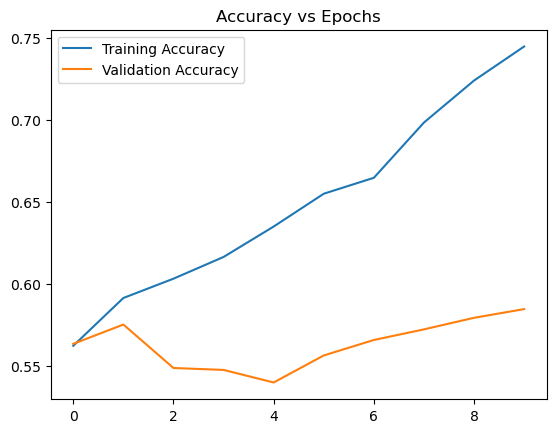

In [64]:
plt.plot(loaded_history['accuracy'])
plt.plot(loaded_history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Accuracy vs Epochs')
plt.show()

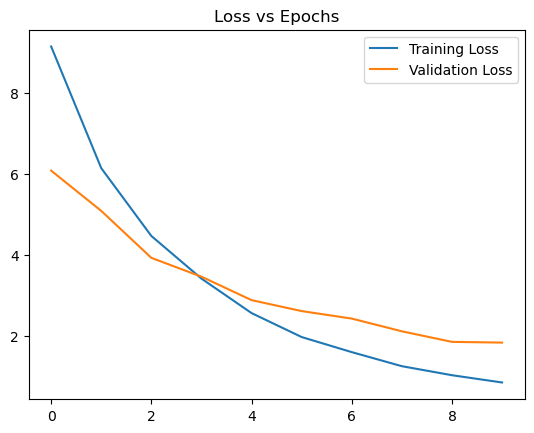

In [65]:
plt.plot(loaded_history['loss'])
plt.plot(loaded_history['val_loss'])
plt.title('Loss vs Epochs')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

# Importing Test Set

In [117]:
with tf.device(device):
    with jsonlines.open('dataset/test_seen.jsonl') as reader:
        # Initialize empty lists to store the dataset
        images_test = []
        labels_test = []
        text_test = []

        # Iterate over each line in the file
        for line in reader:
            # Append the image, label, and text to their respective lists
            img = cv2.imread('dataset/' + line['img'])
            img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
            
            images_test.append(img_resized)
            labels_test.append(line['label'])
            text_test.append(line['text'])

        # Convert the lists to numpy arrays
        images_test = np.array(images_test)
        labels_test = np.array(labels_test)
        text_test = np.array(text_test)

In [118]:
with tf.device(device):
    # Tokenize and pad the text input
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(text_test)
    sequences = tokenizer.texts_to_sequences(text_test)
    padded_sequences_test = pad_sequences(sequences, maxlen=100)

# Score Evaluation

In [119]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [133]:
y_pred = loaded_model.predict([images_test, padded_sequences_test])

32/32 [==============================] - 21s 663ms/step


In [134]:
y_pred = np.round(y_pred)

In [209]:
# calculate metrics
accuracy = accuracy_score(labels_test, y_pred)
f1 = f1_score(labels_test, y_pred, average='binary')
precision = precision_score(labels_test, y_pred, average='binary')
recall = recall_score(labels_test, y_pred, average='binary')

# print metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 score: {:.2f}%".format(f1 * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))

Accuracy: 60.01%
F1 score: 38.29%
Precision: 52.78%
Recall: 23.27%


In [88]:
from sklearn.metrics import classification_report

report = classification_report(labels_test, y_pred, target_names=["Non-hateful", "Hateful"])
print(report)

              precision    recall  f1-score   support

 Non-hateful       0.63      0.77      0.70      1250
     Hateful       0.40      0.25      0.31       750

    accuracy                           0.58      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.55      0.58      0.55      2000



# 50 Samples of Hate and Not-Hate

In [210]:
with tf.device(device):
    with jsonlines.open('dataset/test_unseen.jsonl') as reader:
        # Initialize empty lists to store the dataset
        images_test = []
        labels_test = []
        text_test = []
        
        hate = 0
        non_hate = 0

        # Iterate over each line in the file
        for line in reader:
    
            if line['label'] == 1 and hate < 50:
                
                # Append the image, label, and text to their respective lists
                img = cv2.imread('dataset/' + line['img'])
                img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
                
                images_test.append(img_resized)
                labels_test.append(line['label'])
                text_test.append(line['text'])
                
                hate += 1
                
            elif line['label'] == 0 and non_hate < 50:
                
                # Append the image, label, and text to their respective lists
                img = cv2.imread('dataset/' + line['img'])
                img_resized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
                
                images_test.append(img_resized)
                labels_test.append(line['label'])
                text_test.append(line['text'])
                
                non_hate += 1
                
            if hate == 50 and non_hate == 50:
                break

        # Convert the lists to numpy arrays
        images_test = np.array(images_test)
        labels_test = np.array(labels_test)
        text_test = np.array(text_test)

In [213]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(text_test)
sequences = tokenizer.texts_to_sequences(text_test)
padded_sequences_test = pad_sequences(sequences, maxlen=100)

# TSNE Plot

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [215]:
from sklearn.manifold import TSNE

# Extract features from last embedding layer
last_layer_model = Model(inputs=loaded_model.input, outputs=loaded_model.get_layer('dense_5').output)
test_features = last_layer_model.predict([images_test, padded_sequences_test])

4/4 [==============================] - 2s 482ms/step


In [216]:
test_features = np.round(test_features)

In [217]:
# Use T-SNE to reduce dimensionality of features
tsne = TSNE(n_components=1, perplexity=30, n_iter=1000, random_state=42)
tsne_features = tsne.fit_transform(test_features)

In [ ]:
# Plot T-SNE features
plt.scatter(tsne_features[labels_test == 0, 0], tsne_features[labels_test == 0, 1], label='0.0')
plt.scatter(tsne_features[labels_test == 1, 0], tsne_features[labels_test == 1, 1], label='1.0')
plt.legend()
plt.title('multi-modal Features TSNE Projections')
plt.show()